In [3]:
import tensorflow as tf
from keras import backend as K
#If having a gpu on the computer
tf.config.experimental.list_physical_devices('GPU')
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
import nltk
from nltk.corpus import treebank
from keras import Input, regularizers
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import *
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, merge
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.utils import plot_model

from keras.models import load_model, Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,precision_score,classification_report,accuracy_score,confusion_matrix,f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import itertools
import pickle
import pandas as pd
import re
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [5]:
#==========================================================================================#
#========================Processing the data for the models================================#

In [4]:
nltk.download('treebank')
sentences = treebank.tagged_sents()
sentences = sentences[:len(sentences)//4]
tags = set([
    tag for sentence in treebank.tagged_sents()
    for _, tag in sentence
])
print('nb_tags: %sntags: %s' % (len(tags), tags))
#print(len(sentences))

train_test_cutoff = int(.80 * len(sentences))
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

#These properties could include information about
# previous and next words as well as prefixes and suffixes.
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
        :param sentence_terms: [w1, w2, ...]
        :type sentence_terms: list
        :param index: the index of the word
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

def untag(tagged_sentence):
    """
    Remove the tag for each tagged term.
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return:
    """
    X, y = [], []
    for pos_tags in tagged_sentences:
            for index, (term, class_) in enumerate(pos_tags):
                X.append(add_basic_features(untag(pos_tags), index))
                y.append(class_)
    return X, y

X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

#Our neural network takes vectors as inputs, so we need to convert our dict features to vectors.
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)
# Convert dict features to vectors
preX_train = X_train
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)
# Encode class values as integers
prey_train = y_train
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

# Convert integers to dummy variables (one hot encoded)
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

def untagger(tagged_sentences):
    X = []
    for pos_tags in tagged_sentences:
                X.append(untag(pos_tags))
    return X
simple_train_sentences = untagger(training_sentences)
#maxlen = max([len(s) for s in sentences])
#print ('Maximum sentence length:', maxlen)

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Precisit\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


nb_tags: 46ntags: {'WP$', 'NNS', 'IN', 'NNPS', '.', 'RB', 'FW', 'LS', 'VBP', '-NONE-', 'WP', '#', '``', 'EX', '-RRB-', '$', 'VBZ', 'CD', 'POS', 'PRP', 'RBR', 'NNP', 'UH', 'CC', 'PRP$', 'JJS', 'RP', 'JJR', 'NN', '-LRB-', 'RBS', 'SYM', 'VBD', 'VBN', 'VBG', 'WRB', 'TO', 'DT', 'JJ', ':', 'MD', 'VB', "''", 'PDT', ',', 'WDT'}


In [3]:
#==============================================================================#
#========================Building a model======================================#

In [22]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
#Basic sequential model
def build_model(input_dim, hidden_neurons, output_dim):
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}

clf = KerasClassifier(**model_params)
hist = clf.fit(X_train, y_train)
clf.model.save('keras_mlp.h5')


Train on 14560 samples, validate on 4970 samples
Epoch 1/5
14560/14560 [==============================] - 24s 2ms/step - loss: 1.9579 - accuracy: 0.5407 - val_loss: 0.6860 - val_accuracy: 0.8316

In [ ]:
#================================================================================================#
#========================Building a LSTM model======================================#
#https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-visualize-word-embeddings-part-2-ca137a42a97d

In [6]:
from keras.layers import add
units = 64
_input = Input(shape=[20323], dtype='int32')

embedded = Embedding(X_train.shape[1], 100, input_length=20323)(_input)
activations = LSTM(units, return_sequences= True)(embedded)

attention = Dense(1, activation = 'tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2,1])(attention)

sent_representation = add([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis = -2),
                             output_shape=(units,))(sent_representation)

probabilities = Dense(43,activation='softmax')(sent_representation)

lstm2_model = Model(input=_input, output = probabilities)
lstm2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm2_model.fit(X_train, y_train, validation_split=0.4, validation_data = (X_val, y_val), epochs = 2)
lstm2_model.save('lstmwAttention.h5') #Save trained model to keras_mlp.h5


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 14560 samples, validate on 4970 samples
Epoch 1/2
14560/14560 [==============================] - 8853s 608ms/step - loss: 0.7006 - val_loss: 0.7009

AttributeError: 'Model' object has no attribute 'model'

In [5]:
def create_lstm_model():
    model_lstm = Sequential()
    model_lstm.add(Embedding(X_train.shape[1], 100, input_length=20323))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Conv1D(64, 5, activation='relu'))
    model_lstm.add(MaxPooling1D())
    model_lstm.add(LSTM(100))
    #model_lstm.add(Activation('softmax'))
    model_lstm.add(Dense(43, activation='sigmoid')) #Or sigmoid
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_lstm

model_lstm = create_lstm_model()
model_lstm.fit(X_train, y_train, validation_split=0.4, validation_data = (X_val, y_val), epochs = 2)
model_lstm.save('lstm.h5') #Save trained model to keras_mlp.h5



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 14560 samples, validate on 4970 samples
Epoch 1/2


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_1/convolution}}]]
	 [[Mean/_119]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_1/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
#================================================================================================#
#========================Building a CNN model======================================#
#https://www.kaggle.com/hamishdickson/cnn-for-sentence-classification-by-yoon-kim/data

In [5]:
num_filters = 100
embedding_dim = 200
sequence_length = 46
inputs_2 = Input(shape=(X_train.shape[1],), dtype='int32')

def create_cnn_model():
    model_cnn = Sequential()
    model_cnn.add(Embedding(X_train.shape[1], 100, input_length=20323))
    model_cnn.add(Conv1D(num_filters, kernel_size= 3, activation='relu', kernel_regularizer=regularizers.l2(3)))
    model_cnn.add(MaxPooling1D())
    model_cnn.add(Flatten())
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(43, activation='softmax'))
    model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_cnn

model_cnn = create_cnn_model()
hist_2 = model_cnn.fit(X_train, y_train, validation_split=0.4, epochs = 2,validation_data =(X_val,y_val), batch_size=10)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 14560 samples, validate on 4970 samples
Epoch 1/2
14560/14560 [==============================] - 131s 9ms/step - loss: 5.9102 - accuracy: 0.9845 - val_loss: 0.0270 - val_accuracy: 0.9943

In [6]:
model_cnn.model.save('cnn.h5')

D:\Anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [ ]:
#=================================================================================#
#========================Building a RF model======================================#
#https://blog.goodaudience.com/introduction-to-random-forest-algorithm-with-python-9efd1d8f0157
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [33]:
#{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
#Fitting 3 folds for each of 25 candidates, totalling 75 fits
#{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': True}
RF_model = RandomForestClassifier(n_estimators = 1000, min_samples_split = 10, min_samples_leaf = 1, max_features = 'auto', max_depth =  80, bootstrap = False)
histRF = RF_model.fit(X_train, y_train)
RF_predictions = RF_model.predict(X_test)

RF_model2 = RandomForestClassifier(bootstrap = False)
histRF2 = RF_model2.fit(X_train, y_train)
RF_predictions2 = RF_model2.predict(X_test)

In [34]:
with open('rf.sav', 'wb') as modelfile:
    pickle.dump(RF_model, modelfile)

with open('rf2.sav', 'wb') as modelfile:
    pickle.dump(RF_model2, modelfile)

#print(RF_model.score(X_test, y_test)) #0.713890535467299
#print(RF_model2.score(X_test, y_test)) #0.8842126062043074

In [ ]:
#==================================================================================#
#========================Visualize the result======================================#

In [ ]:
y_pred = clf.model.predict(X_test, verbose=1).argmax(-1)
y_true = y_test.argmax(-1)


In [37]:
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')


    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')
    fig.tight_layout(pad=3.0)
    return fig

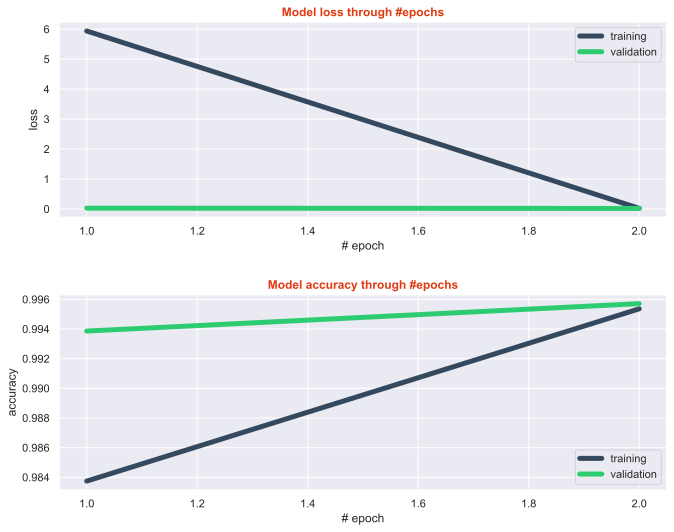

In [38]:
plt1 = plot_model_performance(
        train_loss=hist_2.history.get('loss', []),
        train_acc=hist_2.history.get('accuracy', []),
        train_val_loss=hist_2.history.get('val_loss', []),
        train_val_acc=hist_2.history.get('val_accuracy', [])
    )
plt1.savefig('cnn_performance.png')


In [9]:
col = ['nb_terms','term','is_first','is_last','is_capitalized','is_all_caps',
       'is_all_lower','prefix-1','prefix-2','prefix-3','suffix-1','suffix-2',
       'suffix-3','prev_word','next_word']
#modelname.feature_importance_
y = RF_model.feature_importances_
#plot
fig, ax = plt.subplots()
width = 0.4 # the width of the bars
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature')
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

NameError: name 'RF_model' is not defined

In [ ]:
#================================================================================#
#========================Visulize the model======================================#

In [36]:
con_tags = {'$',',','-NONE-','JJR','NNS','SYM','TO','UH','VBD','VBN','VBZ','WP$'}
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 10))
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

model = load_model("cnn.h5")
y_predCNN = model.predict(X_test, verbose=1).argmax(-1)
cnf_matrix = confusion_matrix(y_test , y_predCNN)
plot_confusion_matrix(f1_score(y_test, y_predCNN, average='macro'), cnf_matrix, target_names=con_tags, title='Confusion matrix', normalize=False)

5061/5061 [==============================] - 65s 13ms/step

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
def plot_acc():
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_acc()

In [6]:
#Test the accuracies
cnn = load_model('cnn.h5')
loss, acc = cnn.evaluate(X_test, y_test)
print(loss)
print(acc)

5061/5061 [==============================] - 8s 2ms/step

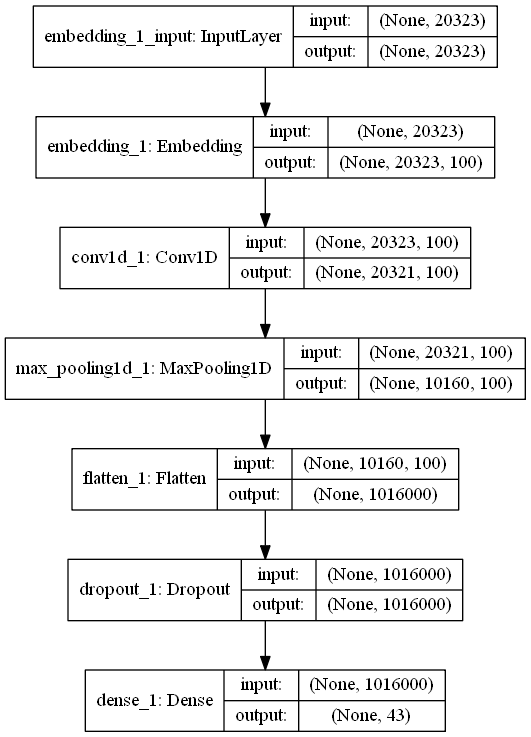

In [22]:
#print(cnn.summary())
plot_model(cnn, to_file='model_plot_cnn.png', show_shapes=True, show_layer_names=True)

In [23]:
lstm = load_model('lstm.h5')
lossL, accL = lstm.evaluate(X_test, y_test)
print('LSTM Test loss: ', lossL)
print('LSTM Test accuracy: ', accL)
plot_model(lstm.model, to_file='model_plot_lstm_attention.png', show_shapes=True, show_layer_names=True)

5061/5061 [==============================] - 1336s 264ms/step

TypeError: cannot unpack non-iterable float object


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

5061/5061 [==============================] - 730s 144ms/step

D:\Anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


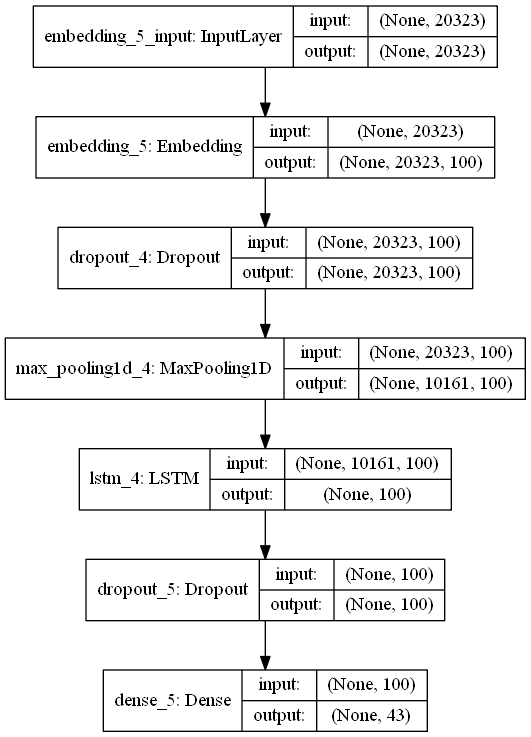

In [6]:
lstm2 = load_model('lstm2.h5')
lossL2, accL2 = lstm2.evaluate(X_test, y_test)
print('LSTM Test loss: ', lossL2)
print('LSTM Test accuracy: ', accL2)
plot_model(lstm2.model, to_file='model_plot_lstm.png', show_shapes=True, show_layer_names=True)

In [9]:
rf =  pickle.load(open('rf.sav', 'rb'))
result = rf.score(X_test, y_test)
f1 = f1_score(y_test, result)
print('RF Test result: ', result)
print('RF f1: ', f1)

#print('Parameters currently in use:\n')
#print(RF_model.get_params())

TypeError: Singleton array 0.713890535467299 cannot be considered a valid collection.